(optional)

In [ ]:
# from google.colab import drive
# import os+
# drive.mount('/content/drive')

In [ ]:
# os.chdir('...')

# **HW5: Brain signal classification**
In *HW 5*, you need to finish:

1.  Model Implementation Part: Implement LSTM and EEGNet models to predict the label of each samples.

2.  Model Competition Part: Implementing a model to reach better accuracy performance.

In [43]:
import numpy as np
import os
import math
import csv
import matplotlib.pyplot as plt
# Import the packages you need here
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler



In [44]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [45]:
data = np.load('data.npz')
label = np.load('label.npz')

In [46]:
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']

Y_train = label['Y_train']
Y_val = label['Y_val']

In [47]:
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200), (152, 22, 200), (190, 22, 200))

In [48]:
Y_train.shape, Y_val.shape

((604, 1), (152, 1))

In [49]:
X_temp = []
for sample in X_train:
    sample = sample.T
    X_temp.append(sample)
X_train = np.array(X_temp)
print('X_train: ',X_train.shape)

X_temp = []
for sample in X_val:
    sample = sample.T
    X_temp.append(sample)
X_val = np.array(X_temp)
print('X_val: ', X_val.shape)

X_temp = []
for sample in X_test:
    sample = sample.T
    X_temp.append(sample)
X_test = np.array(X_temp)
print('X_test: ', X_test.shape)

X_train:  (604, 200, 22)
X_val:  (152, 200, 22)
X_test:  (190, 200, 22)


In [50]:
Y_train = Y_train.reshape(Y_train.shape[0])
Y_train = np.eye(6)[Y_train.astype(int)]
print(Y_train.shape)

Y_val = Y_val.reshape(Y_val.shape[0])
Y_val = np.eye(6)[Y_val.astype(int)]
print(Y_val.shape)

(604, 6)
(152, 6)


## Model Implementation Part

### LSTM

In [53]:
# Build your model here:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(
    units=32,
    input_shape=(200, 22),
    return_sequences=True
))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(6, activation='softmax'))
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200, 32)           7040      
                                                                 
 time_distributed_3 (TimeDis  (None, 200, 3)           99        
 tributed)                                                       
                                                                 
 flatten_6 (Flatten)         (None, 600)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 3606      
                                                                 
Total params: 10,745
Trainable params: 10,745
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
10/10 [==============================] - 3s 110ms/step - loss: 1.7920 - accuracy: 0.2649 - val_loss: 1.5604 - val_accuracy: 0.2961
Epoch 2/50
10/10 [==============================] - 1s 58ms/step - loss: 1.2997 - accuracy: 0.5331 - val_loss: 1.2341 - val_accuracy: 0.5132
Epoch 3/50
10/10 [==============================] - 1s 59ms/step - loss: 0.9595 - accuracy: 0.7053 - val_loss: 0.9685 - val_accuracy: 0.6645
Epoch 4/50
10/10 [==============================] - 1s 56ms/step - loss: 0.6874 - accuracy: 0.8063 - val_loss: 0.7859 - val_accuracy: 0.7434
Epoch 5/50
10/10 [==============================] - 1s 57ms/step - loss: 0.4842 - accuracy: 0.8791 - val_loss: 0.6340 - val_accuracy: 0.7961
Epoch 6/50
10/10 [==============================] - 1s 57ms/step - loss: 0.3429 - accuracy: 0.9139 - val_loss: 0.5410 - val_accuracy: 0.8224
Epoch 7/50
10/10 [==============================] - 1s 58ms/step - loss: 0.2455 - accuracy: 0.9421 - val_loss: 0.4774 - val_accuracy: 0.8224
Epoch 8/50
1

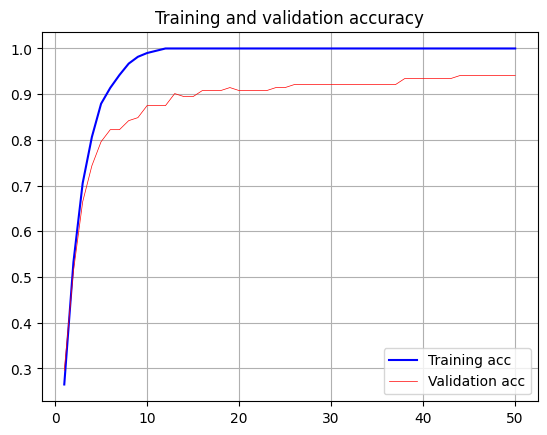

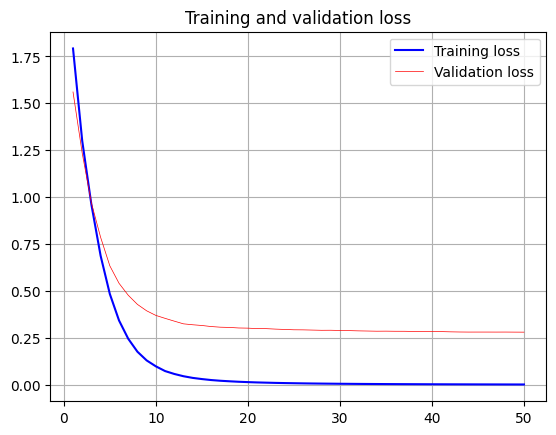

In [54]:
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
)

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc', linewidth=0.5)
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.grid()
# 儲存acc學習曲線
# plt.savefig('./acc.png')
plt.show()

# 畫出loss學習曲線
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=0.5)
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
# 儲存loss學習曲線
# plt.savefig('loss.png')
plt.show()

In [55]:
temp = model.predict(X_test)
output = np.argmax(temp, axis=1).reshape(temp.shape[0], 1).astype(int)
print(output.shape)
assert(output.shape == (190, 1))
np.savetxt('lstm_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 17ms/step
(190, 1)


### EEGNet

In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

In [57]:
C = 22
T = 200
D = 2
dropoutRate = 0.5
F1 = 8
F2 = 16
norm_rate = 0.25
dropoutType = 'Dropout'
kernLength = 64
nb_classes = 6

X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
X_train = X_train.reshape(604, 22, 200, 1)
X_val = X_val.reshape(152, 22, 200, 1)
X_test = X_test.reshape(190, 22, 200, 1)
X_train.shape, X_val.shape, X_test.shape

((604, 22, 200, 1), (152, 22, 200, 1), (190, 22, 200, 1))

In [58]:
model = keras.models.Sequential()

# Block 1
model.add(Conv2D(F1, (1, kernLength), padding='same', input_shape=(C, T, 1), use_bias=False))
model.add(BatchNormalization())
model.add(DepthwiseConv2D((C, 1), use_bias=False, depth_multiplier=D, depthwise_constraint= max_norm(1.)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(AveragePooling2D((1, 4)))
model.add(Dropout(dropoutRate))

# Block 2
model.add(SeparableConv2D(F2, (1, 16), use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(AveragePooling2D(1,8))
model.add(Dropout(dropoutRate))

# Fully connected layer
model.add(Flatten())
model.add(Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate)))
model.add(Activation('softmax', name='softmax'))

model.summary()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 22, 200, 8)        512       
                                                                 
 batch_normalization_9 (Batc  (None, 22, 200, 8)       32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 200, 16)       352       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 200, 16)       64        
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 1, 200, 16)        0         
                                                      

Epoch 1/50
10/10 [==============================] - 2s 88ms/step - loss: 1.8753 - accuracy: 0.1937 - val_loss: 1.7184 - val_accuracy: 0.3750
Epoch 2/50
10/10 [==============================] - 1s 70ms/step - loss: 1.6547 - accuracy: 0.3626 - val_loss: 1.6577 - val_accuracy: 0.6118
Epoch 3/50
10/10 [==============================] - 1s 70ms/step - loss: 1.5486 - accuracy: 0.5166 - val_loss: 1.5948 - val_accuracy: 0.6908
Epoch 4/50
10/10 [==============================] - 1s 70ms/step - loss: 1.4365 - accuracy: 0.6308 - val_loss: 1.5270 - val_accuracy: 0.7434
Epoch 5/50
10/10 [==============================] - 1s 69ms/step - loss: 1.3062 - accuracy: 0.6623 - val_loss: 1.4614 - val_accuracy: 0.7434
Epoch 6/50
10/10 [==============================] - 1s 70ms/step - loss: 1.1864 - accuracy: 0.6987 - val_loss: 1.3825 - val_accuracy: 0.7763
Epoch 7/50
10/10 [==============================] - 1s 70ms/step - loss: 1.0779 - accuracy: 0.7368 - val_loss: 1.3022 - val_accuracy: 0.7961
Epoch 8/50
10

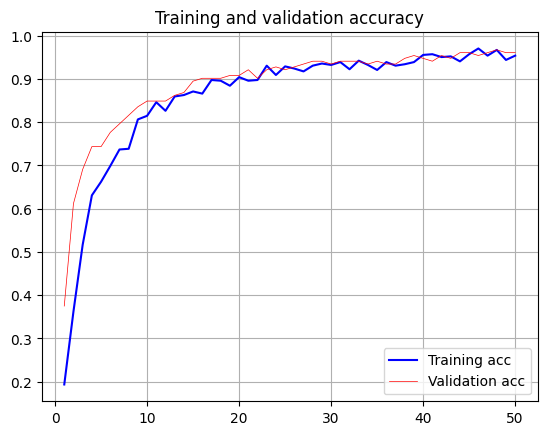

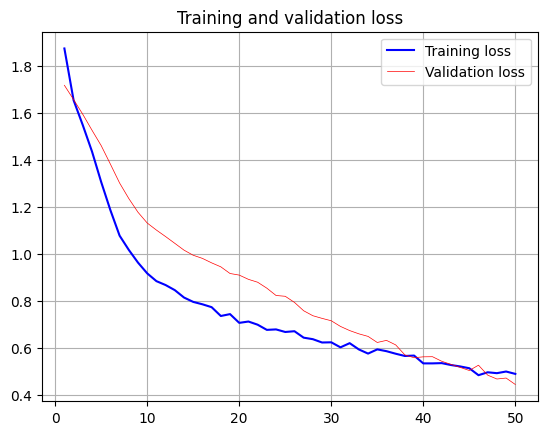

In [59]:
history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
)

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc', linewidth=0.5)
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.grid()
# 儲存acc學習曲線
# plt.savefig('./acc.png')
plt.show()

# 畫出loss學習曲線
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=0.5)
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
# 儲存loss學習曲線
# plt.savefig('loss.png')
plt.show()

In [60]:
temp = model.predict(X_test)
output = np.argmax(temp, axis=1).reshape(temp.shape[0], 1).astype(int)
print(output.shape)
assert(output.shape == (190, 1))
np.savetxt('eegnet_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 7ms/step
(190, 1)


## Model Competition Part

In [67]:
# Build your model here:
model = keras.models.Sequential()

# Block 1
model.add(Conv2D(F1, (1, kernLength), padding='same', input_shape=(C, T, 1), use_bias=False))
model.add(BatchNormalization())
model.add(DepthwiseConv2D((C, 1), use_bias=False, depth_multiplier=D, depthwise_constraint= max_norm(1.)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(AveragePooling2D((1, 4)))
model.add(Dropout(dropoutRate))

# Block 2
model.add(SeparableConv2D(F2, (1, 16), use_bias=False, padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(AveragePooling2D(1,8))
model.add(Dropout(dropoutRate))

# Fully connected layer
model.add(Flatten())
model.add(Dense(nb_classes, name='dense', kernel_constraint=max_norm(norm_rate)))
model.add(Activation('softmax', name='softmax'))

model.summary()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 22, 200, 8)        512       
                                                                 
 batch_normalization_15 (Bat  (None, 22, 200, 8)       32        
 chNormalization)                                                
                                                                 
 depthwise_conv2d_5 (Depthwi  (None, 1, 200, 16)       352       
 seConv2D)                                                       
                                                                 
 batch_normalization_16 (Bat  (None, 1, 200, 16)       64        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 1, 200, 16)        0         
                                                     

Epoch 1/300
19/19 [==============================] - 2s 48ms/step - loss: 1.7826 - accuracy: 0.2649 - val_loss: 1.6545 - val_accuracy: 0.5592
Epoch 2/300
19/19 [==============================] - 1s 39ms/step - loss: 1.5880 - accuracy: 0.4305 - val_loss: 1.5862 - val_accuracy: 0.7105
Epoch 3/300
19/19 [==============================] - 1s 38ms/step - loss: 1.4292 - accuracy: 0.6142 - val_loss: 1.5112 - val_accuracy: 0.8224
Epoch 4/300
19/19 [==============================] - 1s 38ms/step - loss: 1.2271 - accuracy: 0.7119 - val_loss: 1.3850 - val_accuracy: 0.8092
Epoch 5/300
19/19 [==============================] - 1s 38ms/step - loss: 1.1046 - accuracy: 0.7781 - val_loss: 1.2740 - val_accuracy: 0.8289
Epoch 6/300
19/19 [==============================] - 1s 38ms/step - loss: 0.9934 - accuracy: 0.7815 - val_loss: 1.1853 - val_accuracy: 0.8421
Epoch 7/300
19/19 [==============================] - 1s 39ms/step - loss: 0.9343 - accuracy: 0.8162 - val_loss: 1.1029 - val_accuracy: 0.8816
Epoch 

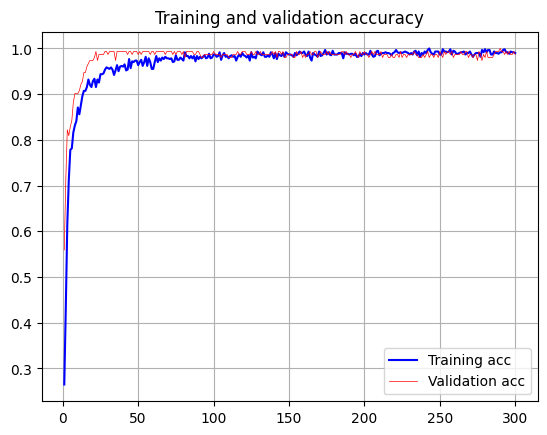

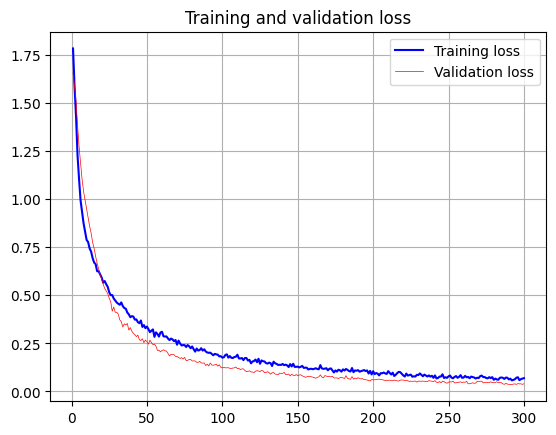

In [68]:
# my_callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.05, patience=30, mode='max')]
# my_callback = [tf.keras.callbacks.ModelCheckpoint(
#     filepath='model_save/model_{epoch:03d}_{val_accuracy:.2f}.hdf5',
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max'
# )]

# model = keras.models.load_model('model_save/model_251_0.99.hdf5')

history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, Y_val),
    # callbacks=my_callback
)

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc', linewidth=0.5)
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.grid()
# 儲存acc學習曲線
# plt.savefig('./acc.png')
plt.show()

# 畫出loss學習曲線
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=0.5)
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
# 儲存loss學習曲線
# plt.savefig('loss.png')
plt.show()

In [65]:
temp = model.predict(X_test)
output = np.argmax(temp, axis=1).reshape(temp.shape[0], 1).astype(int)
print(output.shape)
assert(output.shape == (190, 1))
np.savetxt('competition_output.csv', output, delimiter=",")

6/6 [==============================] - 0s 7ms/step
(190, 1)
